# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
if os.path.exists(f"{root_dir}/.env"):
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/jp/Documents/GitHub/mlfs-book
HopsworksSettings initialized!


In [2]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util
import pytz
from IPython.display import display


In [3]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 18, 16, 11, 55, 638989)

In [4]:
def make_features(df):
    df = df.copy()
    df = df.set_index("date")

    # lag features
    for lag in [1, 2, 3]:
        df[f"pm25_lag{lag}"] = df["pm25"].shift(lag)

    # rolling windows
    for window in [3, 7, 14]:
        df[f"pm25_roll{window}"] = df["pm25"].shift(1).rolling(window).mean()

    df = df.reset_index()
    return df

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [5]:
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']

street_list = list(location['sensor'].keys())

2025-11-18 16:11:55,659 INFO: Initializing external client
2025-11-18 16:11:55,660 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-18 16:11:56,250 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-18 16:11:57,112 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286350


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [6]:
def get_model(mr, use_more_features, sensor):
    if use_more_features:
        name = "extended_air_quality_xgboost_model"+sensor
    else:
        name = "air_quality_xgboost_model"+sensor

    retrieved_model = mr.get_model(
        name=name,
        version=1,
    )

    fv = retrieved_model.get_feature_view()

    # Download the saved model artifacts to a local directory
    saved_model_dir = retrieved_model.download()

    return fv, saved_model_dir

In [7]:
def load_xgboost_model(saved_model_dir):

    # Loading the XGBoost regressor model and label encoder from the saved model directory
    # retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
    retrieved_xgboost_model = XGBRegressor()

    retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

    return retrieved_xgboost_model

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [8]:
def get_data(use_more_features):
    weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
    )   
    batch_data = weather_fg.filter(weather_fg.date >= today).read()
    batch_data = batch_data.set_index('date').sort_index().reset_index()

    if use_more_features:
        # Retrieve feature groups
        air_quality_fg = fs.get_feature_group(
            name='air_quality',
            version=1,
        )
        
        selected_features = air_quality_fg.select(['pm25', 'date']).join(weather_fg.select_features(), on=['city'])

        feature_view = fs.get_or_create_feature_view(
            name='air_quality_fv',
            description="weather features with air quality as the target",
            version=1,
            labels=['pm25'],
            query=selected_features,
        )

        feature_view = feature_view.query.read()
        start_date = (today - pd.Timedelta(days=14)).replace(tzinfo=pytz.UTC)
        past_data = feature_view[feature_view['date'] >= start_date]

        return weather_fg, batch_data, past_data
    
    else:
        return weather_fg, batch_data, None
    

### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [9]:
def make_predictions(retrieved_xgboost_model, use_more_features, past_data, batch_data):
    if use_more_features:
        history = past_data.copy()        
        forecast = batch_data.copy()         
        forecast["predicted_pm25"] = 0.0

        for idx in range(len(forecast)):
            current_forecast_day = forecast.iloc[[idx]].copy()

            # Add day to forecast (t+1) to history df (t-14 days)
            df_inference = pd.concat([history, current_forecast_day], ignore_index=True)
            df_inference = make_features(df_inference)

            # Row of the day to forecast (t+1)
            forecast_date = current_forecast_day["date"].iloc[0]
            row = df_inference[df_inference["date"] == forecast_date]

            X = row[[
                'temperature_2m_mean', 
                'precipitation_sum', 
                'wind_speed_10m_max',
                'wind_direction_10m_dominant',
                'pm25_lag1',
                'pm25_lag2',
                'pm25_lag3',
                'pm25_roll3',
                'pm25_roll7',
                'pm25_roll14',
            ]]

            # Predict pm25 at t+1 (1 day)
            y_pred = retrieved_xgboost_model.predict(X)[0]

            # Store prediction in forecast
            forecast.loc[idx, "predicted_pm25"] = y_pred

            # Add prediction to history so the next day can use it
            history = pd.concat([
                history,
                pd.DataFrame({
                    "date": [forecast_date],
                    "pm25": [y_pred],
                    "temperature_2m_mean": current_forecast_day["temperature_2m_mean"].values,
                    "precipitation_sum": current_forecast_day["precipitation_sum"].values,
                    "wind_speed_10m_max": current_forecast_day["wind_speed_10m_max"].values,
                    "wind_direction_10m_dominant": current_forecast_day["wind_direction_10m_dominant"].values,
                })
            ], ignore_index=True)
        forecast["predicted_pm25"] = forecast["predicted_pm25"].astype("float32")
        batch_data = forecast

    else:
        batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
        batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
    
    return batch_data

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [10]:
def save_predictions(batch_data, street, city, country):
    batch_data['street'] = street
    batch_data['city'] = city
    batch_data['country'] = country
    # Fill in the number of days before the date on which you made the forecast (base_date)
    batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
    batch_data = batch_data.sort_values(by=['date'])

    # Get or create feature group
    monitor_fg = fs.get_or_create_feature_group(
        name='aq_predictions',
        description='Air Quality prediction monitoring',
        version=1,
        primary_key=['city','street','date','days_before_forecast_day'],
        event_time="date"
    )

    monitor_fg.insert(batch_data, wait=True)
    
    return monitor_fg, batch_data

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

In [ ]:
def create_hindcast(monitor_fg, weather_fg, retrieved_xgboost_model):
    # We will create a hindcast chart for  only the forecasts made 1 day beforehand
    monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
    
    air_quality_fg = fs.get_feature_group(name='air_quality', version=1)
    air_quality_df = air_quality_fg.read()

    outcome_df = air_quality_df[['date', 'pm25']]
    preds_df =  monitoring_df[['date', 'predicted_pm25']]

    hindcast_df = pd.merge(preds_df, outcome_df, on="date")
    hindcast_df = hindcast_df.sort_values(by=['date'])

    # If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
    if len(hindcast_df) == 0:
        hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
    
    return hindcast_df


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [14]:
def upload(pred_file_path, hindcast_file_path, street):
    dataset_api = project.get_dataset_api()
    str_today = today.strftime("%Y-%m-%d")
    if dataset_api.exists("Resources/airquality") == False:
        dataset_api.mkdir("Resources/airquality")
    dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
    dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

    proj_url = project.get_url()
    print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

---

2025-11-18 16:24:29,939 INFO: There is no parent information


Downloading: 0.000%|          | 0/533256 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/85026 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/28178 elapsed<00:00 remaining<?

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.33s) 
2025-11-18 16:24:36,229 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather` as features for the query. To include primary key and event time use `select_all`.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.91s) 


Uploading Dataframe: 100.00% |██████████| Rows 12/12 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286350/jobs/named/aq_predictions_1_offline_fg_materialization/executions
2025-11-18 16:24:58,266 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2025-11-18 16:25:01,466 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 16:25:20,863 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 16:27:13,417 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 16:27:13,572 INFO: Waiting for log aggregation to finish.
2025-11-18 16:27:35,915 INFO: Execution finished successfully.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.35s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.11s) 


Uploading /Users/jp/Documents/GitHub/mlfs-book/docs/air-quality/assets/img/bromsebrovag_8/pm25_forecast.png: 0…

Uploading /Users/jp/Documents/GitHub/mlfs-book/docs/air-quality/assets/img/bromsebrovag_8/pm25_hindcast_1day.p…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1286350/settings/fb/path/Resources/airquality

 Sensor bromsebrovag_8 has been run and uploaded correctly!
2025-11-18 16:27:47,799 INFO: There is no parent information


Downloading: 0.000%|          | 0/533256 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/82458 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/28178 elapsed<00:00 remaining<?

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.82s) 
2025-11-18 16:27:57,036 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather` as features for the query. To include primary key and event time use `select_all`.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.90s) 


Uploading Dataframe: 100.00% |██████████| Rows 12/12 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286350/jobs/named/aq_predictions_1_offline_fg_materialization/executions
2025-11-18 16:28:20,828 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2025-11-18 16:28:24,036 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 16:28:27,246 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 16:30:39,145 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 16:30:39,380 INFO: Waiting for log aggregation to finish.
2025-11-18 16:31:18,613 INFO: Execution finished successfully.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.23s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.86s) 


Uploading /Users/jp/Documents/GitHub/mlfs-book/docs/air-quality/assets/img/ostervag_17/pm25_forecast.png: 0.00…

Uploading /Users/jp/Documents/GitHub/mlfs-book/docs/air-quality/assets/img/ostervag_17/pm25_hindcast_1day.png:…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1286350/settings/fb/path/Resources/airquality

 Sensor ostervag_17 has been run and uploaded correctly!


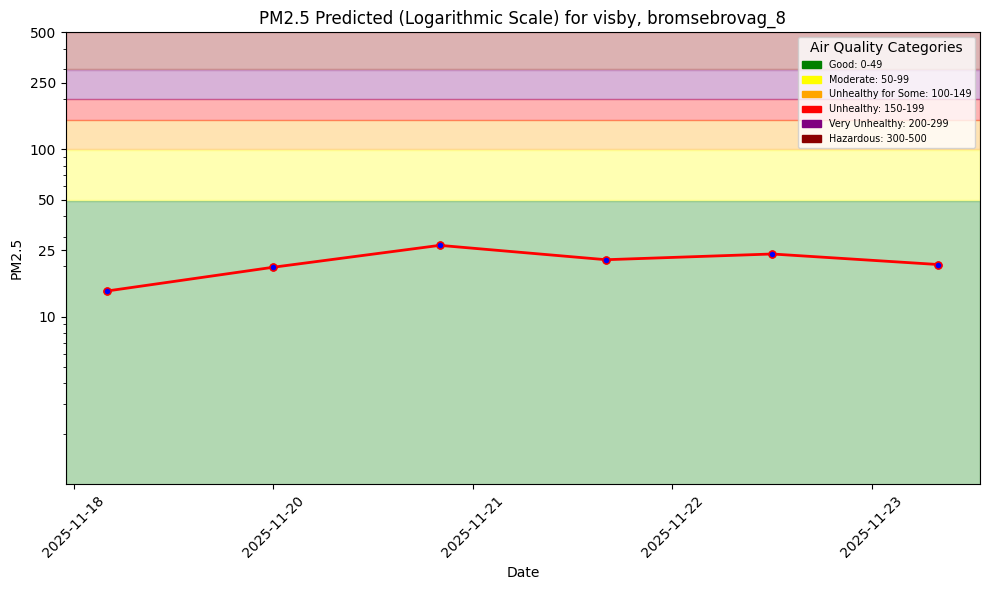

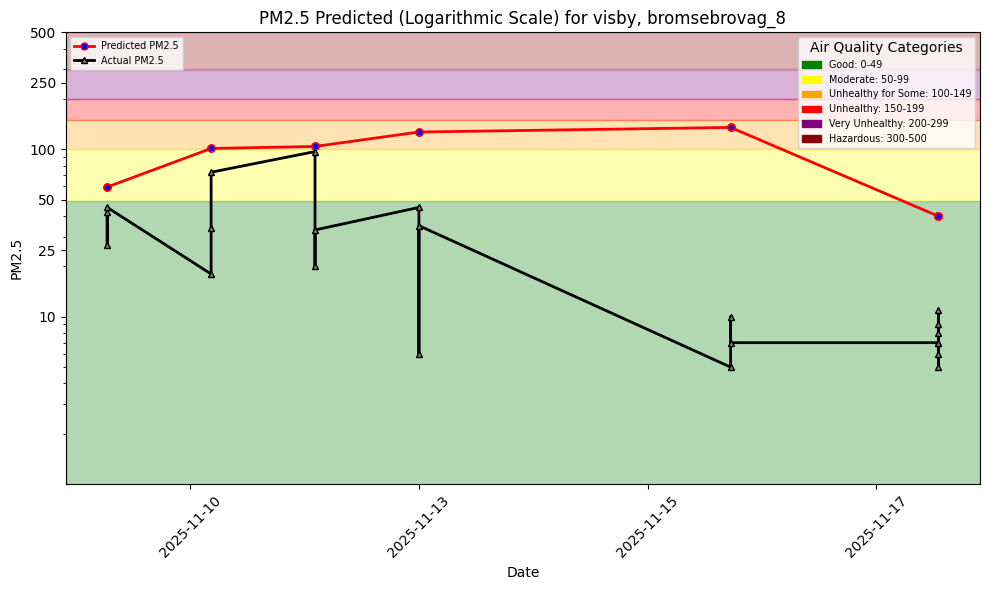

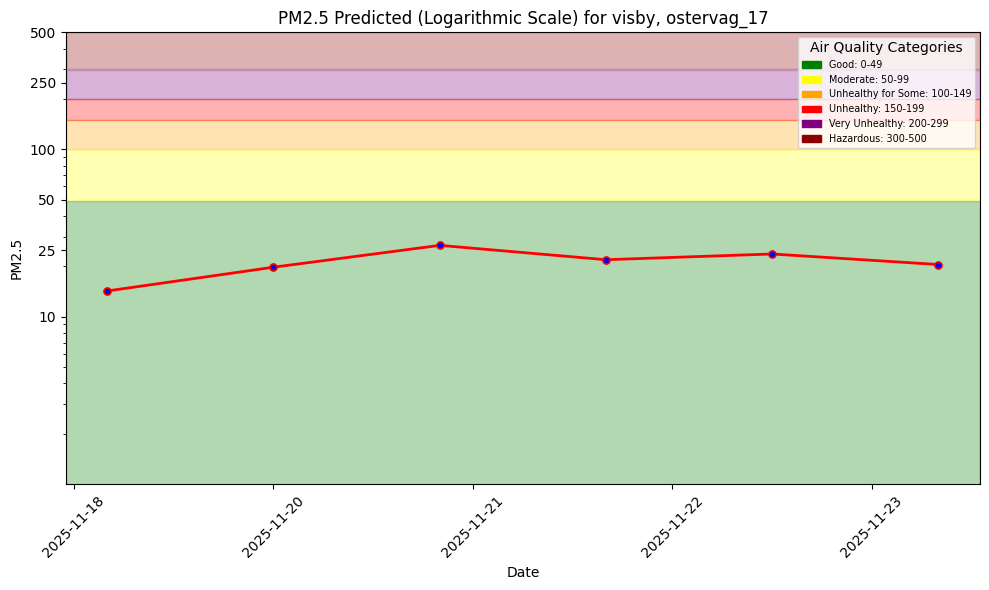

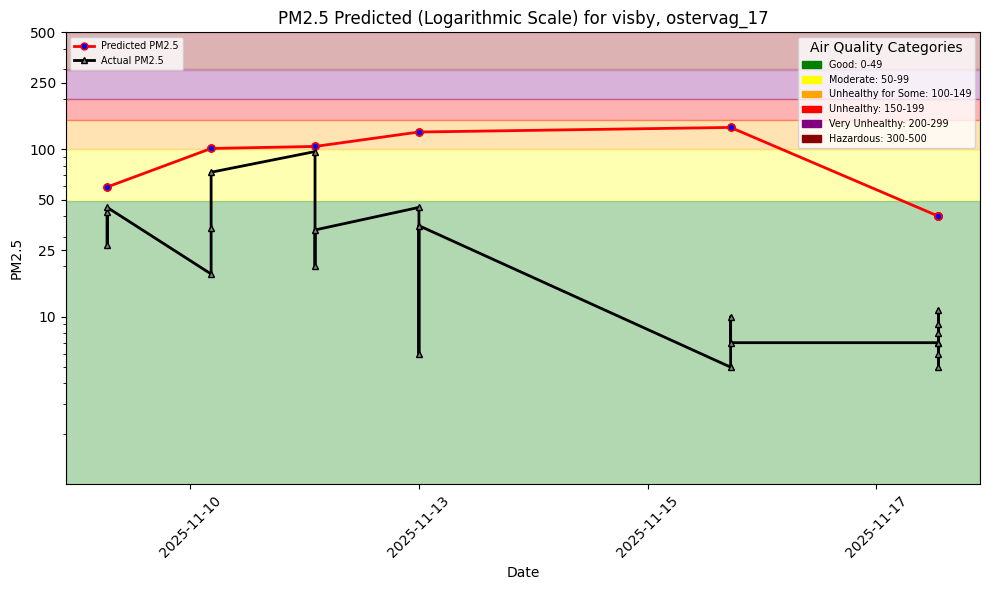

In [17]:
use_more_features = True
mr = project.get_model_registry()

for sensor in street_list:
    
    fv, saved_model_dir = get_model(mr, use_more_features, sensor)
    retrieved_xgboost_model = load_xgboost_model(saved_model_dir)

    weather_fg, batch_data, past_data = get_data(use_more_features)
    batch_data = make_predictions(retrieved_xgboost_model, use_more_features, past_data, batch_data)
    monitor_fg, batch_data = save_predictions(batch_data, sensor, city, country)

    # Create dir to save results
    sensor_dir = f"{root_dir}/docs/air-quality/assets/img/{sensor}"
    os.makedirs(sensor_dir, exist_ok=True)

    # Createpredictions
    pred_file_path = f"{sensor_dir}/pm25_forecast.png"
    util.plot_air_quality_forecast(city, sensor, batch_data, pred_file_path)
    
    # Create hindcasts
    hindcast_file_path = f"{sensor_dir}/pm25_hindcast_1day.png"
    hindcast_df = create_hindcast(monitor_fg, weather_fg, retrieved_xgboost_model)
    util.plot_air_quality_forecast(city, sensor, hindcast_df, hindcast_file_path, hindcast=True)

    # Upload pictures
    upload(pred_file_path, hindcast_file_path, sensor)

    print('\n Sensor ' + sensor + ' has been run and uploaded correctly! \n')
    